# Input data processing for the Clean Cooking Explorer (CCE)

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
from onsstove.onsstove import DataProcessor

In [3]:
from decouple import config
import numpy as np
import os

## 1. Creating a project
First, we will create an instance of the `MCA` object that will be used to add raw datasets, process them and generate the required output datapackages for the CCE and OnSSTOVE. The `MCA` object accepts three optional argument `project_crs`, `cell_size` and `output_directory`. The first, sets the Coordinate reference System (crs) to use in the project, this means that all datasets will be reprojected to match such crs. The second, is used to define the desired cell size (i.e. width and height in meters) of the output datasets, which will be used to ensure that all output datasets match such cell size. The third, is simply used as the output folder in which all results will be writen, this parameter defaults to `output`.

In [4]:
nepal = DataProcessor(project_crs=3857, cell_size=(1000, 1000))
nepal.output_directory = 'output' # Any of the attributes can be set at any time like this

## 2. Adding a PostgreSQL data base connection
Datasets can be read from any local path (or in some cases from urls) or from a PostgreSQL database. For the later, we would need to define the PostgreSQL connection, passing the database name `db`, the `POSTGRES_USER` and the `POSTGRES_KEY`.

In [5]:
nepal.set_postgres(db='nepal', POSTGRES_USER=config('POSTGRES_USER'), POSTGRES_KEY=config('POSTGRES_KEY'))

## 3. Adding a mask layer
A vector layer can be added as a mask, which will be later used to mask/clip all output datasets to the layer boundaries. For this, we use the `add_mask_layer` method providing a `name` for the layer, a `layer_path` from where to read the data and in this case the `postgres` argument as `True` that will tell that the layer is found in the PostgreSQL database.

In [6]:
nepal.add_mask_layer(category='Administrative', name='Country boundaries', 
                     layer_path=r"..\EGI Energy Systems\06 Projects\2021 Nepal Geospatial cooking\02 - work\GIS-data\Other\Administrative boundaries\NPL_adm0_Nepal0.shp")

## 4. Adding data layers
Similarly, we can add data layers using the `add_layer` method. A layer `name`, `layer_path` and `postgres` conection also need to be provided (the `postgres` conection defaults to `False`). In addition, the following arguments can be passed:
* `category`: this is used to group all datasets into a category in the final output, e.g. `demand` or `supply`. 
* `layer_type`: thi argument is required with two possible options `raster` or `vector`, we should pass either one according to the dataset you are adding. 
* `distance`: the method to be used to calculate the distance raster for this layer. 
    * For `raster` layers, only `log` is available. This will create a logarithmic representation of the original raster. If this is not desired, we should pass `None` to the `distance` parameter (this is the defaul value), which will take the original raster as the distance raster.
    * For `vector` layers, two options are available `proximity` and `time_travel`. `proximity`, calculates a distance raster using the vectors (e.g. points, lines, polygons) as origin; the output raster will have the same dimentions and cell size as the `base_layer` (i.e. see below). `time_travel`, will need a friction raster (which can be added later) that will be used to calculate the least cost path to every cell taking the vectors as starting points.
* `normalization`: currently only `MinMax` normalization is available. This is used to normalize the distance rasters in a 0 to 1 range, which will be used later to calculate the CCE Demand, Supply and Clean Cooking potential indexes.
* `inverse`: we can specify if the scale of the ormalization need to be reversed, depending on the nature of the dataset.

In [7]:
nepal.add_layer(category='demand', name='Population', layer_path='data/population_npl_2018-10-01.tif',
                layer_type='raster', normalization='MinMax', inverse=False, 
                distance='log', base_layer=False, resample='sum')

nepal.add_layer(category='demand', name='Education facilities', layer_path='places.education_facilities', postgres=True,
                layer_type='vector', normalization='MinMax', inverse=True, 
                distance='proximity', distance_limit=5000)

nepal.layers['demand']['Population'].layer[np.isnan(nepal.layers['demand']['Population'].layer)] = 0
nepal.layers['demand']['Population'].save(os.path.join(nepal.output_directory, 'demand', 'Population'))

In [8]:
nepal.add_layer(category='demand', name='Health facilities', layer_path='places.health_facilities', postgres=True,
                layer_type='vector', normalization='MinMax', inverse=True, 
                distance='proximity', distance_limit=5000)

nepal.add_layer(category='supply', name='Existent substations', 
                layer_path=r"..\EGI Energy Systems\06 Projects\2021 Nepal Geospatial cooking\02 - work\GIS-data\Supply\Power network\Substations\Substations_Nepal_Updated.shp", 
                layer_type='vector', query='Substation == "Existing"', normalization='MinMax', inverse=True, 
                distance='proximity', distance_limit=30000)

nepal.add_layer(category='supply', name='Planned substations', 
                layer_path=r"..\EGI Energy Systems\06 Projects\2021 Nepal Geospatial cooking\02 - work\GIS-data\Supply\Power network\Substations\Substations_Nepal_Updated.shp", 
                layer_type='vector', query='Substation != "Existing"', normalization='MinMax', inverse=True, 
                distance='proximity', distance_limit=30000)

nepal.add_layer(category='supply', name='Existent MV lines', 
                layer_path=r"..\EGI Energy Systems\06 Projects\2021 Nepal Geospatial cooking\02 - work\GIS-data\Supply\Power network\MV-network\Nepal_DL0.shp",
                layer_type='vector', query='Status == "In Service"', normalization='MinMax', inverse=True, 
                distance='proximity', distance_limit=30000)

nepal.add_layer(category='supply', name='Planned MV lines', 
                layer_path=r"..\EGI Energy Systems\06 Projects\2021 Nepal Geospatial cooking\02 - work\GIS-data\Supply\Power network\MV-network\Nepal_DL0.shp",
                layer_type='vector', query='Status != "In Service"', 
                normalization='MinMax', inverse=True, 
                distance='proximity', distance_limit=30000)

nepal.add_layer(category='supply', name='MG hydropower', 
                layer_path=r"..\EGI Energy Systems\06 Projects\2021 Nepal Geospatial cooking\02 - work\GIS-data\Supply\Power network\MG-hydro\micro_hydropower.shp",
                layer_type='vector', 
                normalization='MinMax', inverse=True, 
                distance='proximity', distance_limit=3000)

## 5. Adding a base layer
A raster base layer is needed to make every output match its grid and extent. For this, two additional options need to be passed to the `add_layer` method:
* `base_layer`: if `True` the added layer will be considered as the base layer. 
* `resample`: this is the resampling method to be used when resampling this layer to the desired `cell_size` if a `cell_size` is provided.

In [9]:
nepal.add_layer(category='supply', name='Biomass', layer_path=r"..\EGI Energy Systems\06 Projects\2021 Nepal Geospatial cooking\02 - work\GIS-data\Other\Forest cover\Global Forest Cover Change (GFCC).tif",
                layer_type='raster', normalization='MinMax', inverse=False, base_layer=True, resample='nearest',
                distance='travel_time', distance_limit=5)

## 6. Adding a friction raster to a vector layer
After adding a vector layer, a raster friction layer can be associated to the vector layer in order to calculate a travel time dataset for it. To do so, we can call the vector layer we want by using the `layers` variable and calling the `category` and the `name` of the vector dataset between quotes and square brackets, and calling the `add_friction_raster` method. This method only needs the path of the raster `raster_path`.

In [10]:
nepal.layers['supply']['Biomass'].add_friction_raster(raster=r"..\EGI Energy Systems\06 Projects\2021 Nepal Geospatial cooking\02 - work\GIS-data\Other\Walking friction\2020_walking_only_friction_surface.geotiff",
                                                      resample='average')

In [11]:
nepal.add_layer(category='supply', name='LPG dealers', layer_path=r"..\EGI Energy Systems\06 Projects\2021 Nepal Geospatial cooking\02 - work\GIS-data\Supply\LPG\Nepal_Gas_12Jun2021_Final4.shp",
                postgres=False, layer_type='vector', normalization='MinMax', inverse=True, 
                distance='travel_time')

nepal.layers['supply']['LPG dealers'].add_friction_raster(raster=r"..\EGI Energy Systems\06 Projects\2021 Nepal Geospatial cooking\02 - work\GIS-data\Other\Motorized friction\2020_motorized_friction_surface.geotiff",
                                                          resample='average')

## Relative Wealth Index

In [12]:
nepal.add_layer(category='demand', name='Wealth', 
                layer_path=r"..\EGI Energy Systems\06 Projects\2021 Nepal Geospatial cooking\02 - work\GIS-data\Demand\Wealth Index\Wealth index 2011.tif",
                layer_type='raster', normalization='MinMax', inverse=False, resample='nearest')

In [13]:
nepal.layers['demand']['Wealth'].layer[nepal.layers['demand']['Wealth'].layer<0] = np.nan
nepal.layers['demand']['Wealth'].meta['nodata'] = np.nan
nepal.layers['demand']['Wealth'].save(os.path.join(nepal.output_directory, 'demand', 'Wealth'))

## 7. Mask and reproject layers

In [14]:
nepal.mask_layers(datasets={'supply': ['Biomass', 'LPG dealers']})

In [15]:
nepal.reproject_layers(datasets='all')

In [16]:
nepal.align_layers(datasets='all')

## 8. Calculate distance rasters and normalize

In [17]:
nepal.get_distance_rasters(datasets='all')

In [18]:
nepal.layers

{'demand': {'Population': RasterLayer(name='Population'),
  'Education facilities': VectorLayer(name='Education facilities'),
  'Health facilities': VectorLayer(name='Health facilities'),
  'Wealth': RasterLayer(name='Wealth')},
 'supply': {'Existent substations': VectorLayer(name='Existent substations'),
  'Planned substations': VectorLayer(name='Planned substations'),
  'Existent MV lines': VectorLayer(name='Existent MV lines'),
  'Planned MV lines': VectorLayer(name='Planned MV lines'),
  'MG hydropower': VectorLayer(name='MG hydropower'),
  'Biomass': RasterLayer(name='Biomass'),
  'LPG dealers': VectorLayer(name='LPG dealers')}}

## Scenarios

### Policy-makers perspective
The clean cooking explorer identifies areas with high demand for clean cooking access by first identifying areas with high demand.  The Nepal Electricity Authority (NEA) is aiming at providing universal electricity access by 2022. Meanwhile, the government has as target to provide electrical cooking in every household by 2028. The first scenario assesses the potential for electrical cooking assuming mini-grids is still not viable and electrical network in current state. The second scenarios assumes expansions in electricity sector and improvement of (current) mini-grids to supply electricity for cooking. By using this scenario a policy maker can identify areas where a larger focus is needed for electricity expansion in order to reach the goals, but also how LPG can cover the potential shortfall.

#### Scenario 1
* Demand: Population and Wealth index
* Supply: LPG and existing electricity infrastructure

In [70]:
scenario = 'Polici-makers 1'

nepal.layers['supply']['Existent MV lines'].distance_raster.inverse = True
# nepal.layers['supply']['Existent substations'].distance_raster.inverse = True
nepal.layers['supply']['LPG dealers'].distance_raster.inverse = True
nepal.layers['demand']['Wealth'].distance_raster.inverse = False


nepal.layers['supply']['Existent MV lines'].distance_raster.distance_limit = 30000
nepal.layers['supply']['Existent substations'].distance_raster.distance_limit = 30000
nepal.layers['supply']['LPG dealers'].distance_raster.distance_limit = float('inf')

nepal.get_demand_index(datasets={'demand': ['Population', 'Wealth']})
nepal.get_supply_index(datasets={'supply': ['Existent MV lines', 'LPG dealers']})
nepal.get_clean_cooking_index()

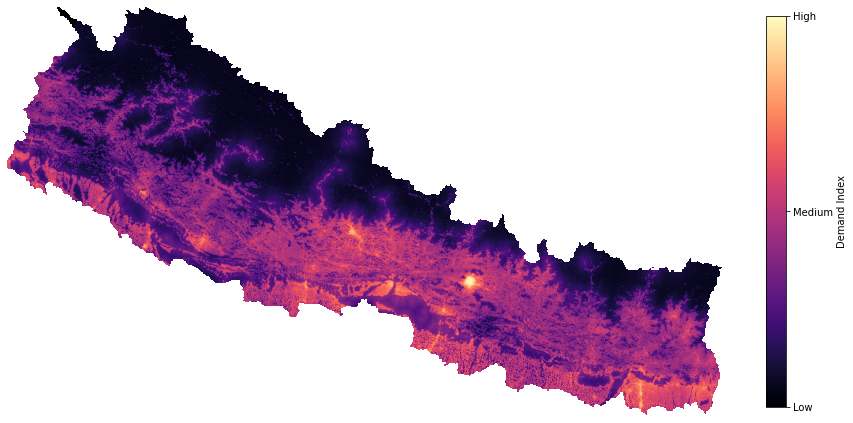

In [71]:
nepal.demand_index.plot(cmap='magma', ticks=[0, 0.5, 1], tick_labels=['Low', 'Medium', 'High'])

In [72]:
nepal.demand_index.save_png(os.path.join(nepal.output_directory, scenario), 
                            cmap='magma', ticks=[0, 0.5, 1], tick_labels=['Low', 'Medium', 'High'])

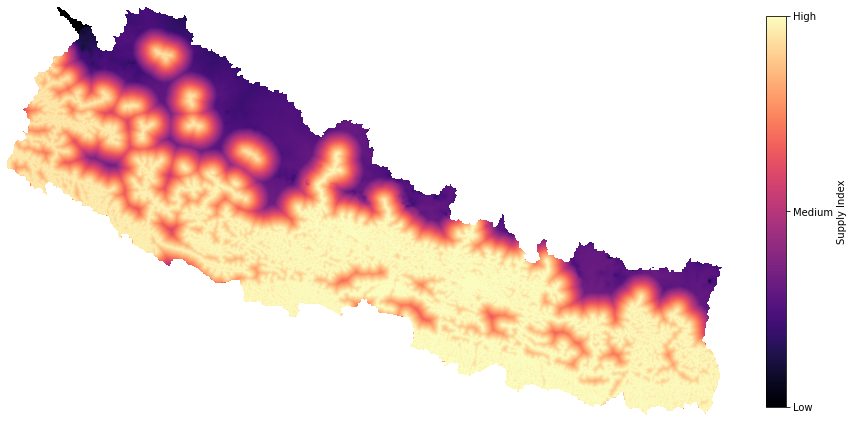

In [73]:
nepal.supply_index.plot(cmap='magma', ticks=[0, 0.5, 1], tick_labels=['Low', 'Medium', 'High'])

In [74]:
nepal.supply_index.save_png(os.path.join(nepal.output_directory, scenario), 
                            cmap='magma', ticks=[0, 0.5, 1], tick_labels=['Low', 'Medium', 'High'])

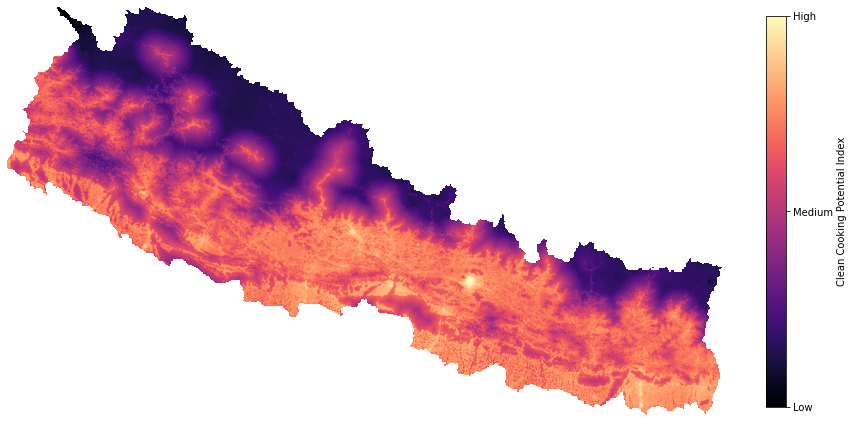

In [75]:
nepal.clean_cooking_index.plot(cmap='magma', ticks=[0, 0.5, 1], tick_labels=['Low', 'Medium', 'High'])

In [76]:
nepal.clean_cooking_index.save_png(os.path.join(nepal.output_directory, scenario), 
                                   cmap='magma', ticks=[0, 0.5, 1], tick_labels=['Low', 'Medium', 'High'])

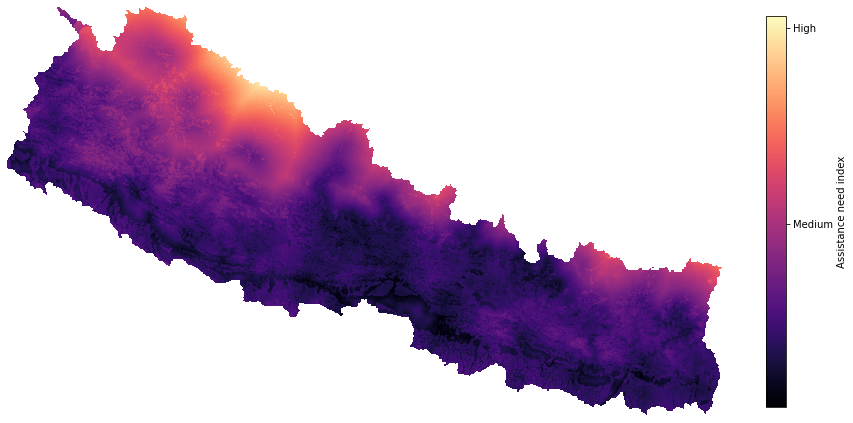

In [77]:
nepal.layers['supply']['Existent MV lines'].distance_raster.inverse = False
nepal.layers['supply']['Existent substations'].distance_raster.inverse = False
nepal.layers['supply']['LPG dealers'].distance_raster.inverse = False
nepal.layers['demand']['Wealth'].distance_raster.inverse = True

nepal.get_assistance_need_index(datasets={'supply': ['Existent MV lines', 'Existent substations', 'LPG dealers'],
                                          'demand': ['Population', 'Wealth']})
nepal.assistance_need_index.plot(cmap='magma', ticks=[0, 0.5, 1], tick_labels=['Low', 'Medium', 'High'])

In [78]:
nepal.assistance_need_index.save_png(os.path.join(nepal.output_directory, scenario), 
                                     cmap='magma', ticks=[0, 0.5, 1], tick_labels=['Low', 'Medium', 'High'])

#### Scenario 2
* Demand: Population and Wealth index
* Supply: Mini-grids hydro, existing and planned electricity infrastructure

In [79]:
scenario = 'Polici-makers 2'

nepal.layers['supply']['Existent MV lines'].distance_raster.inverse = True
nepal.layers['supply']['Existent substations'].distance_raster.inverse = True
nepal.layers['supply']['Planned MV lines'].distance_raster.inverse = True
nepal.layers['supply']['Planned substations'].distance_raster.inverse = True
nepal.layers['supply']['MG hydropower'].distance_raster.inverse = True
nepal.layers['demand']['Wealth'].distance_raster.inverse = False

nepal.layers['supply']['Existent MV lines'].distance_raster.distance_limit = 30000
nepal.layers['supply']['Existent substations'].distance_raster.distance_limit = 30000
nepal.layers['supply']['Planned MV lines'].distance_raster.distance_limit = 30000
nepal.layers['supply']['Planned substations'].distance_raster.distance_limit = 30000
nepal.layers['supply']['MG hydropower'].distance_raster.distance_limit = 3000

nepal.layers['supply']['Existent MV lines'].weight = 2
nepal.layers['supply']['Existent substations'].weight = 2
nepal.layers['supply']['Planned MV lines'].weight = 2
nepal.layers['supply']['Planned substations'].weight = 2
nepal.layers['supply']['MG hydropower'].weight = 1

nepal.get_demand_index(datasets={'demand': ['Population', 'Wealth']})
nepal.get_supply_index(datasets={'supply': ['Existent MV lines', 'Existent substations', 
                                            'Planned MV lines', 'Planned substations', 
                                            'MG hydropower']})
nepal.get_clean_cooking_index()

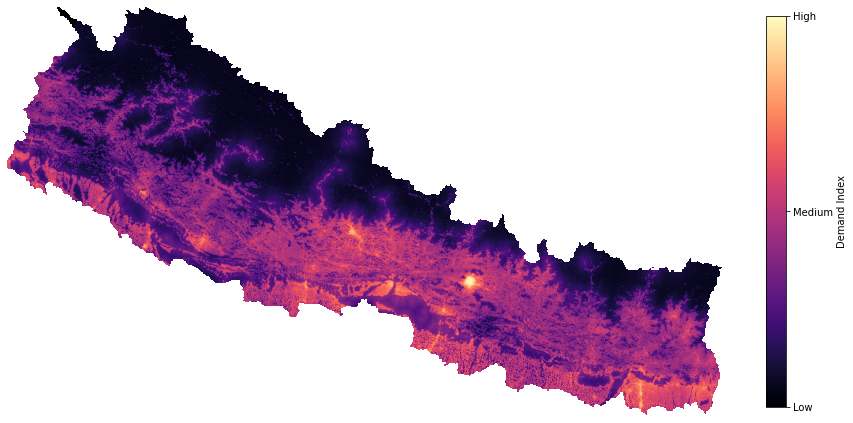

In [80]:
nepal.demand_index.plot(cmap='magma', ticks=[0, 0.5, 1], tick_labels=['Low', 'Medium', 'High'])

In [81]:
nepal.demand_index.save_png(os.path.join(nepal.output_directory, scenario), 
                            cmap='magma', ticks=[0, 0.5, 1], tick_labels=['Low', 'Medium', 'High'])

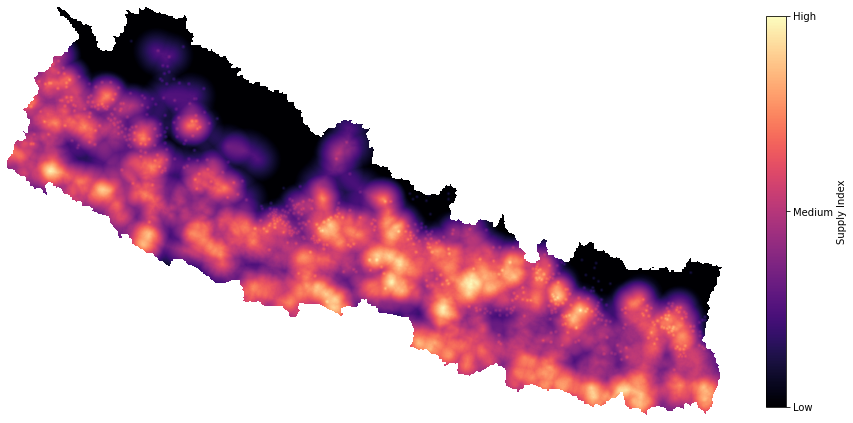

In [82]:
nepal.supply_index.plot(cmap='magma', ticks=[0, 0.5, 1], tick_labels=['Low', 'Medium', 'High'])

In [83]:
nepal.supply_index.save_png(os.path.join(nepal.output_directory, scenario), 
                            cmap='magma', ticks=[0, 0.5, 1], tick_labels=['Low', 'Medium', 'High'])

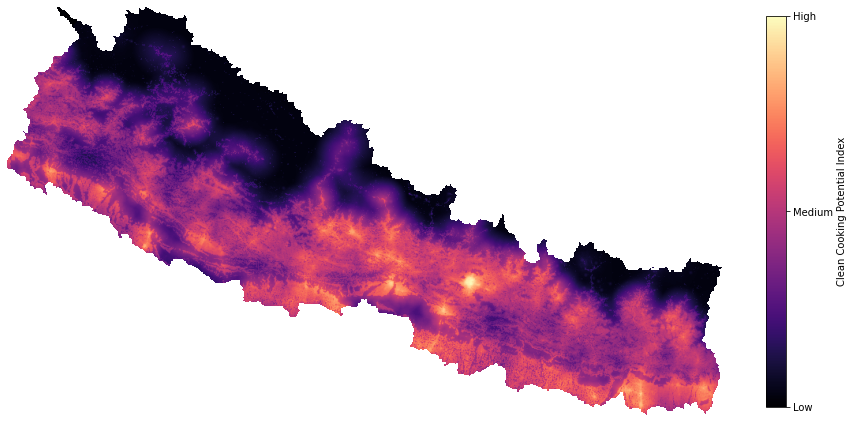

In [84]:
nepal.clean_cooking_index.plot(cmap='magma', ticks=[0, 0.5, 1], tick_labels=['Low', 'Medium', 'High'])

In [85]:
nepal.clean_cooking_index.save_png(os.path.join(nepal.output_directory, scenario), 
                                   cmap='magma', ticks=[0, 0.5, 1], tick_labels=['Low', 'Medium', 'High'])

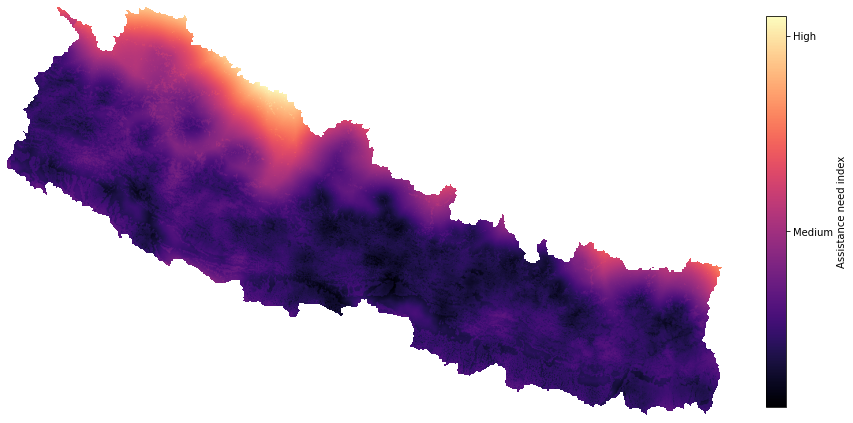

In [88]:
nepal.layers['supply']['Existent MV lines'].distance_raster.inverse = False
nepal.layers['supply']['Existent substations'].distance_raster.inverse = False
nepal.layers['supply']['Planned MV lines'].distance_raster.inverse = False
nepal.layers['supply']['Planned substations'].distance_raster.inverse = False
nepal.layers['supply']['MG hydropower'].distance_raster.inverse = False
nepal.layers['demand']['Wealth'].distance_raster.inverse = True

nepal.get_assistance_need_index(datasets={'supply': ['Existent MV lines', 'Existent substations', 
                                                     'Planned MV lines', 'Planned substations', 
                                                     'MG hydropower'],
                                          'demand': ['Population', 'Wealth']})
nepal.assistance_need_index.plot(cmap='magma', ticks=[0, 0.5, 1], tick_labels=['Low', 'Medium', 'High'])

In [89]:
nepal.assistance_need_index.save_png(os.path.join(nepal.output_directory, scenario), 
                                     cmap='magma', ticks=[0, 0.5, 1], tick_labels=['Low', 'Medium', 'High'])

### Investors perspective
The tool can help investors in different technologies identify high priority areas by taking into account demand, current supply and ability to pay. By using these factors the supply and demand index can be visualized e.g. where the higher demands is and where are there gaps in the supply. Scenarios are available for electricity and LPG. 
#### Scenario 1
* Demand: Population and public uses
* Supply: Existing electricity infrastructure
* Other: Wealth index and GDP

In [90]:
scenario = 'Investors 1'

nepal.layers['supply']['Existent MV lines'].distance_raster.inverse = True
nepal.layers['demand']['Wealth'].distance_raster.inverse = False


nepal.layers['supply']['Existent MV lines'].distance_raster.distance_limit = 30000
nepal.layers['demand']['Education facilities'].distance_raster.distance_limit = 5000
nepal.layers['demand']['Health facilities'].distance_raster.distance_limit = 5000

nepal.layers['supply']['Existent MV lines'].weight = 1
nepal.layers['demand']['Population'].weight = 2
nepal.layers['demand']['Education facilities'].weight = 1
nepal.layers['demand']['Health facilities'].weight = 1
nepal.layers['demand']['Wealth'].weight = 2

nepal.get_demand_index(datasets={'demand': ['Population', 'Education facilities', 'Health facilities', 'Wealth']})
nepal.get_supply_index(datasets={'supply': ['Existent MV lines']})
nepal.get_clean_cooking_index()

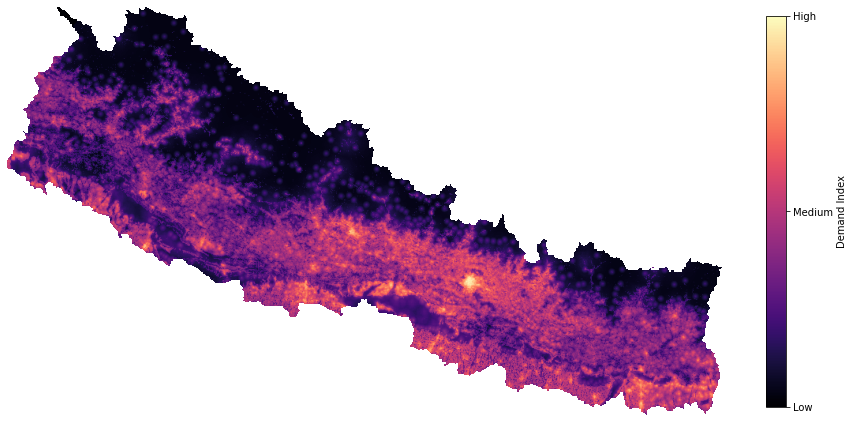

In [91]:
nepal.demand_index.plot(cmap='magma', ticks=[0, 0.5, 1], tick_labels=['Low', 'Medium', 'High'])

In [94]:
nepal.demand_index.save_png(os.path.join(nepal.output_directory, scenario), 
                            cmap='magma', ticks=[0, 0.5, 1], tick_labels=['Low', 'Medium', 'High'])

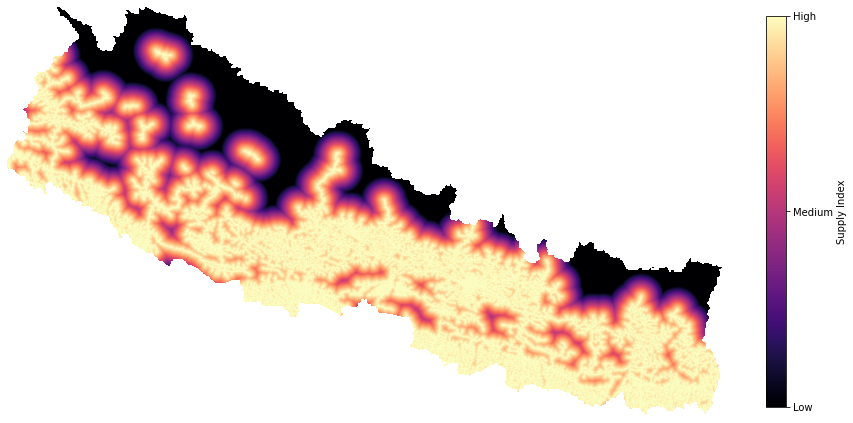

In [92]:
nepal.supply_index.plot(cmap='magma', ticks=[0, 0.5, 1], tick_labels=['Low', 'Medium', 'High'])

In [95]:
nepal.supply_index.save_png(os.path.join(nepal.output_directory, scenario), 
                            cmap='magma', ticks=[0, 0.5, 1], tick_labels=['Low', 'Medium', 'High'])

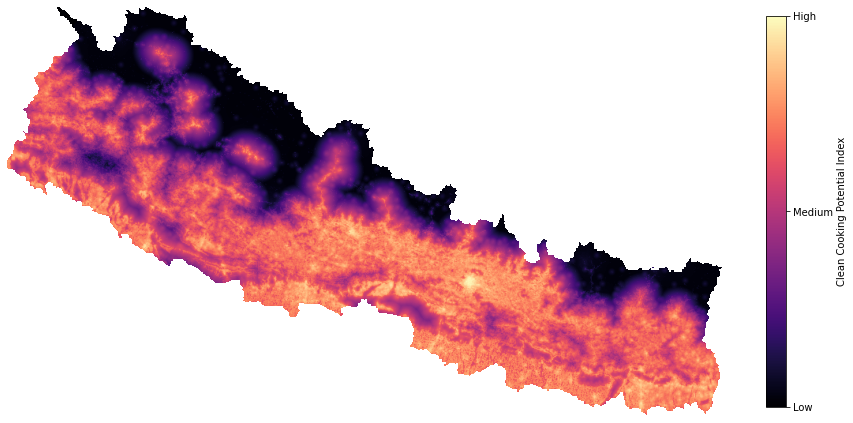

In [93]:
nepal.clean_cooking_index.plot(cmap='magma', ticks=[0, 0.5, 1], tick_labels=['Low', 'Medium', 'High'])

In [96]:
nepal.clean_cooking_index.save_png(os.path.join(nepal.output_directory, scenario), 
                            cmap='magma', ticks=[0, 0.5, 1], tick_labels=['Low', 'Medium', 'High'])

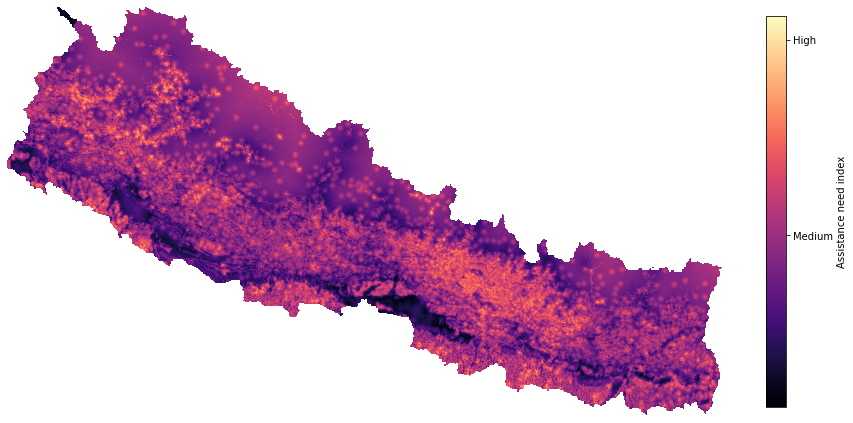

In [108]:
nepal.layers['supply']['Existent MV lines'].distance_raster.inverse = False
nepal.layers['demand']['Wealth'].distance_raster.inverse = True

nepal.get_assistance_need_index(datasets={'supply': ['Existent MV lines'],
                                          'demand': ['Population', 'Wealth', 'Education facilities', 'Health facilities']})
nepal.assistance_need_index.plot(cmap='magma', ticks=[0, 0.5, 1], tick_labels=['Low', 'Medium', 'High'])

In [109]:
nepal.assistance_need_index.save_png(os.path.join(nepal.output_directory, scenario), 
                                   cmap='magma', ticks=[0, 0.5, 1], tick_labels=['Low', 'Medium', 'High'])

#### Scenario 2
* Demand: Population and public uses
* Supply: LPG
* Other: Wealth index and GDP

In [115]:
scenario = 'Investors 2'

nepal.layers['supply']['LPG dealers'].distance_raster.inverse = True
nepal.layers['demand']['Wealth'].distance_raster.inverse = False


# nepal.layers['supply']['LPG dealers'].distance_raster.distance_limit = 5
nepal.layers['demand']['Education facilities'].distance_raster.distance_limit = 5000
nepal.layers['demand']['Health facilities'].distance_raster.distance_limit = 5000

nepal.layers['supply']['LPG dealers'].weight = 1
nepal.layers['demand']['Population'].weight = 2
nepal.layers['demand']['Education facilities'].weight = 1
nepal.layers['demand']['Health facilities'].weight = 1
nepal.layers['demand']['Wealth'].weight = 2

nepal.get_demand_index(datasets={'demand': ['Population', 'Education facilities', 'Health facilities', 'Wealth']})
nepal.get_supply_index(datasets={'supply': ['LPG dealers']})
nepal.get_clean_cooking_index()

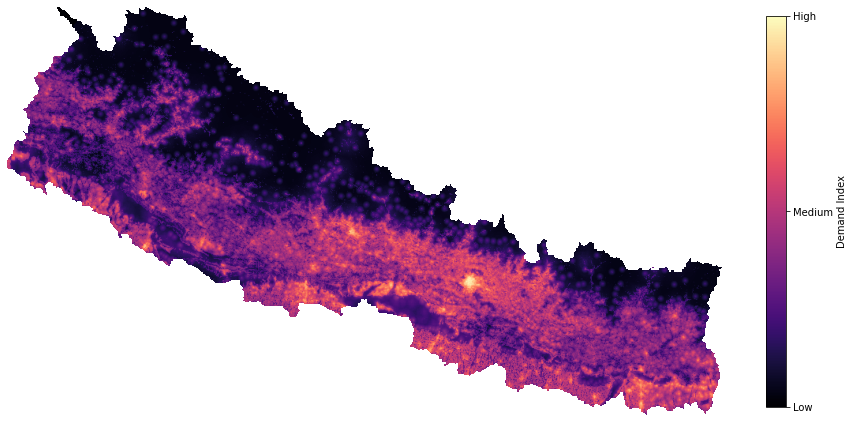

In [116]:
nepal.demand_index.plot(cmap='magma', ticks=[0, 0.5, 1], tick_labels=['Low', 'Medium', 'High'])

In [123]:
nepal.demand_index.save_png(os.path.join(nepal.output_directory, scenario), 
                            cmap='magma', ticks=[0, 0.5, 1], tick_labels=['Low', 'Medium', 'High'])

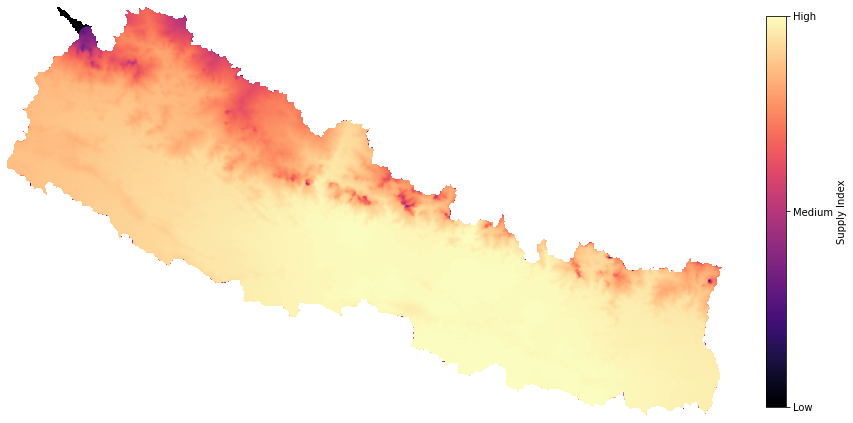

In [117]:
nepal.supply_index.plot(cmap='magma', ticks=[0, 0.5, 1], tick_labels=['Low', 'Medium', 'High'])

In [124]:
nepal.supply_index.save_png(os.path.join(nepal.output_directory, scenario), 
                            cmap='magma', ticks=[0, 0.5, 1], tick_labels=['Low', 'Medium', 'High'])

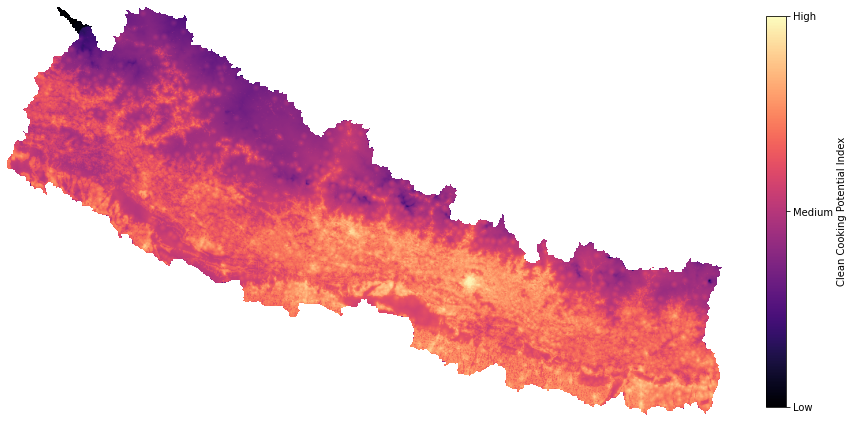

In [118]:
nepal.clean_cooking_index.plot(cmap='magma', ticks=[0, 0.5, 1], tick_labels=['Low', 'Medium', 'High'])

In [125]:
nepal.clean_cooking_index.save_png(os.path.join(nepal.output_directory, scenario), 
                            cmap='magma', ticks=[0, 0.5, 1], tick_labels=['Low', 'Medium', 'High'])

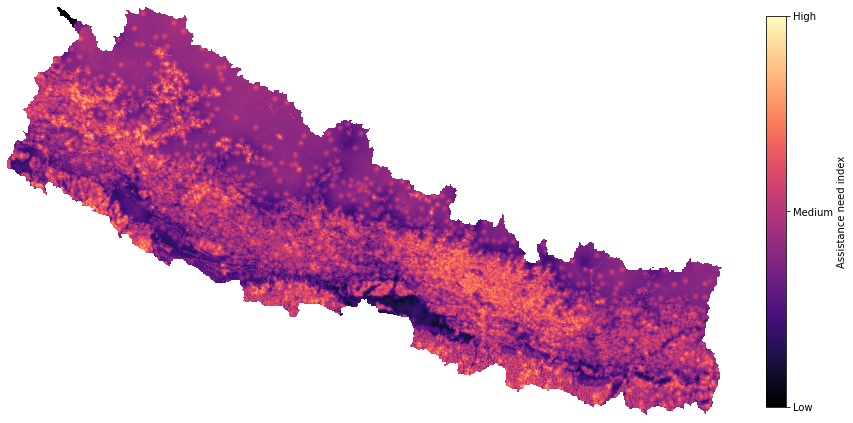

In [122]:
nepal.layers['supply']['LPG dealers'].distance_raster.inverse = False
nepal.layers['demand']['Wealth'].distance_raster.inverse = True

nepal.get_assistance_need_index(datasets={'supply': ['LPG dealers'],
                                          'demand': ['Population', 'Wealth', 'Education facilities', 'Health facilities']})
nepal.assistance_need_index.plot(cmap='magma', ticks=[0, 0.5, 1], tick_labels=['Low', 'Medium', 'High'])

In [126]:
nepal.assistance_need_index.save_png(os.path.join(nepal.output_directory, scenario), 
                                   cmap='magma', ticks=[0, 0.5, 1], tick_labels=['Low', 'Medium', 'High'])